 #              Earthquake Detection Using Machine Learning Algorithm

# 1. Data PreProcessing

In [30]:
# Importing modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql import SparkSession 
from pyspark.sql.types import * 
from pyspark.sql.functions import *
import joblib

# Configure spark session

spark = SparkSession\
    .builder\
    .master('local[2]')\
    .appName('quake_etl')\
    .config('spark.jars.package', 'org.mongodb.spark:mongo-spark-connector 2.12:2.4.1')\
    .getOrCreate()


In [31]:
#Reading the dataset
data = spark.read.csv("quake.csv",header="True")
data.take(1)

[Row(Date='01-02-1965', Time='13:44:18', Latitude='19.246', Longitude='145.616', Type='Earthquake', Depth='131.6', Depth Error=None, Depth Seismic Stations=None, Magnitude='6', Magnitude Type='MW', Magnitude Error=None, Magnitude Seismic Stations=None, Azimuthal Gap=None, Horizontal Distance=None, Horizontal Error=None, Root Mean Square=None, ID='ISCGEM860706', Source='ISCGEM', Location Source='ISCGEM', Magnitude Source='ISCGEM', Status='Automatic')]

In [32]:
#Dropping unwanted columns
dropped_columns =['Depth Error', 'Time', 'Depth Seismic Stations', 'Magnitude Error', 'Magnitude Selamic Stations', 'Azimuthal Root Mean Square', 'Source', 'Location', 'Source', 'Magnitude Source', 'Status','Magnitude Seismic Stations','Azimuthal Gap','Horizontal Distance','Horizontal Error','Root Mean Square','Location Source']
data=data.drop(
    *dropped_columns)
data.show(5)

+----------+--------+---------+----------+-----+---------+--------------+------------+
|      Date|Latitude|Longitude|      Type|Depth|Magnitude|Magnitude Type|          ID|
+----------+--------+---------+----------+-----+---------+--------------+------------+
|01-02-1965|  19.246|  145.616|Earthquake|131.6|        6|            MW|ISCGEM860706|
|01-04-1965|   1.863|  127.352|Earthquake|   80|      5.8|            MW|ISCGEM860737|
|01-05-1965| -20.579| -173.972|Earthquake|   20|      6.2|            MW|ISCGEM860762|
|01-08-1965| -59.076|  -23.557|Earthquake|   15|      5.8|            MW|ISCGEM860856|
|01-09-1965|  11.938|  126.427|Earthquake|   15|      5.8|            MW|ISCGEM860890|
+----------+--------+---------+----------+-----+---------+--------------+------------+
only showing top 5 rows



In [33]:
# Create a year field using Date attriute and add it to the dataframe 
data = data.withColumn('Year', year(to_timestamp('Date','dd-MM-yyyy')))

data.show(5)

+----------+--------+---------+----------+-----+---------+--------------+------------+----+
|      Date|Latitude|Longitude|      Type|Depth|Magnitude|Magnitude Type|          ID|Year|
+----------+--------+---------+----------+-----+---------+--------------+------------+----+
|01-02-1965|  19.246|  145.616|Earthquake|131.6|        6|            MW|ISCGEM860706|1965|
|01-04-1965|   1.863|  127.352|Earthquake|   80|      5.8|            MW|ISCGEM860737|1965|
|01-05-1965| -20.579| -173.972|Earthquake|   20|      6.2|            MW|ISCGEM860762|1965|
|01-08-1965| -59.076|  -23.557|Earthquake|   15|      5.8|            MW|ISCGEM860856|1965|
|01-09-1965|  11.938|  126.427|Earthquake|   15|      5.8|            MW|ISCGEM860890|1965|
+----------+--------+---------+----------+-----+---------+--------------+------------+----+
only showing top 5 rows



In [34]:
#Changing datatype of each attribute
data=data.withColumn('Latitude',data['Latitude'].cast(DoubleType()))\
    .withColumn('Longitude',data['Longitude'].cast(DoubleType()))\
    .withColumn('Depth',data['Depth'].cast(DoubleType()))\
    .withColumn('Magnitude',data['Magnitude'].cast(DoubleType()))\
    .withColumn('Year',data['Year'].cast(IntegerType()))


In [35]:
#Counting null values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+----+--------+---------+----+-----+---------+--------------+---+-----+
|Date|Latitude|Longitude|Type|Depth|Magnitude|Magnitude Type| ID| Year|
+----+--------+---------+----+-----+---------+--------------+---+-----+
|   0|       0|        0|   0|    0|        0|             3|  0|14209|
+----+--------+---------+----+-----+---------+--------------+---+-----+



In [36]:
#Handiling Missing data
df=data.toPandas()
df.interpolate(method ='linear', limit_direction ='forward', inplace=True)
df=df.dropna()
print("Count of Null values in Magnitude Type :", df[['Magnitude Type']].isna().sum().sum())
print("Count of Null values in Year :", df[['Year']].isna().sum().sum())

Count of Null values in Magnitude Type : 0
Count of Null values in Year : 0


In [37]:
# Normalizing Data
from sklearn.preprocessing import LabelEncoder

l1 = LabelEncoder()

l1.fit(df['Magnitude Type'])

df[['Magnitude Type']] = l1.transform(df[['Magnitude Type']].values.ravel())

df.head()

,Date,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,ID,Year
0,01-02-1965,19.246,145.616,Earthquake,131.6,6.0,5,ISCGEM860706,1965.0
1,01-04-1965,1.863,127.352,Earthquake,80.0,5.8,5,ISCGEM860737,1965.0
2,01-05-1965,-20.579,-173.972,Earthquake,20.0,6.2,5,ISCGEM860762,1965.0
3,01-08-1965,-59.076,-23.557,Earthquake,15.0,5.8,5,ISCGEM860856,1965.0
4,01-09-1965,11.938,126.427,Earthquake,15.0,5.8,5,ISCGEM860890,1965.0


In [38]:
print(df.describe())

           Latitude     Longitude         Depth     Magnitude  Magnitude Type  \
count  23403.000000  23403.000000  23403.000000  23403.000000    23403.000000   
mean       1.669936     39.658820     70.780060      5.882352        5.047173   
std       30.112914    125.511614    122.668416      0.422836        2.558753   
min      -77.080000   -179.997000     -1.100000      5.500000        0.000000   
25%      -18.661000    -76.314650     14.565000      5.600000        5.000000   
50%       -3.579000    104.008000     33.000000      5.700000        5.000000   
75%       26.143000    145.037000     54.000000      6.000000        7.000000   
max       86.005000    179.998000    700.000000      9.100000        9.000000   

               Year  
count  23403.000000  
mean    1992.661454  
std       14.426087  
min     1965.000000  
25%     1981.000000  
50%     1993.000000  
75%     2005.000000  
max     2016.000000  


In [39]:
data=spark.createDataFrame(df)
data=data.withColumn('Year',data['Year'].cast(IntegerType()))

In [40]:
df=data.toPandas()
df.dtypes


Date               object
Latitude          float64
Longitude         float64
Type               object
Depth             float64
Magnitude         float64
Magnitude Type      int64
ID                 object
Year                int32
dtype: object

In [41]:
print(df.shape)

(23403, 9)


In [42]:
print("Total number of rows :",len(df))

Total number of rows : 23403



# Random Forest Regressor 

In [43]:
#Extracting Test Set
df_test=spark.read.csv('quake_test.csv',header=True)
df_test=df_test['time','latitude','longitude','depth','mag']
df_test.show(5)

+--------------------+--------+---------+------+---+
|                time|latitude|longitude| depth|mag|
+--------------------+--------+---------+------+---+
|2017-01-02T00:13:...|-36.0365|  51.9288|    10|5.7|
|2017-01-02T13:13:...|  -4.895| -76.3675|   106|5.9|
|2017-01-02T13:14:...|-23.2513| 179.2383|551.62|6.3|
|2017-01-03T09:09:...| 24.0151|  92.0177|    32|5.7|
|2017-01-03T21:19:...|-43.3527| -74.5017| 10.26|5.5|
+--------------------+--------+---------+------+---+
only showing top 5 rows



In [44]:
# Rename fields/Attributes

df_test = df_test.withColumnRenamed('time', 'Date')\
.withColumnRenamed('latitude', 'Latitude')\
.withColumnRenamed('longitude', 'Longitude')\
.withColumnRenamed('mag', 'Magnitude') \
.withColumnRenamed('depth', 'Depth')

# Preview df_test_clean

df_test.show(5)

+--------------------+--------+---------+------+---------+
|                Date|Latitude|Longitude| Depth|Magnitude|
+--------------------+--------+---------+------+---------+
|2017-01-02T00:13:...|-36.0365|  51.9288|    10|      5.7|
|2017-01-02T13:13:...|  -4.895| -76.3675|   106|      5.9|
|2017-01-02T13:14:...|-23.2513| 179.2383|551.62|      6.3|
|2017-01-03T09:09:...| 24.0151|  92.0177|    32|      5.7|
|2017-01-03T21:19:...|-43.3527| -74.5017| 10.26|      5.5|
+--------------------+--------+---------+------+---------+
only showing top 5 rows



In [45]:
#Cast some string fields into numeric fields

df_test = df_test.withColumn('Latitude', df_test['Latitude'].cast(DoubleType()))\
    .withColumn('Depth', df_test['Depth'].cast(DoubleType()))\
    .withColumn('Longitude',df_test['Longitude'].cast(DoubleType()))\
    .withColumn('Magnitude', df_test[ 'Magnitude'].cast(DoubleType()))
df_test.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Depth: double (nullable = true)
 |-- Magnitude: double (nullable = true)



In [46]:
# Splitting train and test set
df_train=data['Latitude','Longitude','Depth','Magnitude']
df_test=df_test['Latitude','Longitude','Depth','Magnitude']
df_train.dropna()
df_test.dropna()


DataFrame[Latitude: double, Longitude: double, Depth: double, Magnitude: double]

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(inputCols=['Latitude', 'Longitude', 'Depth'], outputCol='features')

# Create the model

model_reg=RandomForestRegressor(featuresCol='features', labelCol='Magnitude')

# Chain the assembler with the model in a pipeline 
pipeline=Pipeline(stages=[assembler, model_reg])

# Train the Model
model=pipeline.fit(df_train)

# Make the prediction
pred_results_RF = model.transform(df_test)

In [19]:
df_test_rf=df_test.toPandas()
pred_results_RFR=pred_results_RF.toPandas()
result = pd.concat([df_test_rf[['Magnitude']].reset_index(drop='True'),pred_results_RFR[['prediction']].reset_index(drop='True')],axis=1)
for i in result.columns:
    result[i] = result[i].round(decimals = 0)

In [20]:
# Evaluate the model 
# RMSE should be less than 0.5 for the model to be useful 
evaluator = RegressionEvaluator(labelCol='Magnitude', predictionCol='prediction', metricName='rmse') 
rmse=evaluator.evaluate(pred_results_RF) 
accuracy_rf=metrics.accuracy_score(result[['Magnitude']], result[['prediction']])
print("Accuracy of Random Forest:",accuracy_rf)
print("Absolute error",metrics.mean_absolute_error(result[['Magnitude']], result[['prediction']]))
print('Root Mean Squared Error (RMSE)  = %g' % rmse)

Accuracy of Random Forest: 0.9345088161209067
Absolute error 0.07304785894206549
Root Mean Squared Error (RMSE)  = 0.40265


In [21]:
#Seperating X and y
X=df[['Year','Latitude','Longitude','Depth']]
y=df[['Magnitude']]

In [22]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Support Vector Machine

In [23]:
y_train_svm= y_train[['Magnitude']]*10
y_test_svm= y_test[['Magnitude']]*10

In [24]:
# Implementing SVM

# from sklearn.svm import SVR
# regressor = SVR(kernel = 'rbf')
# regressor.fit(X_train, y_train_svm.values.ravel())
# joblib.dump(regressor,'svmModel.joblib')
# y_pred_svm=regressor.predict(X_test)


import joblib

regressor=joblib.load('svmModel.joblib')

y_pred_svm=regressor.predict(X_test)


In [25]:
y_pred_svm=pd.DataFrame(y_pred_svm)
result=y_test_svm['Magnitude']/10
y_pred_svm.columns=["Predicted values"]
y_pred_svm/=10
result = pd.concat([result.reset_index(drop='True'),y_pred_svm.reset_index(drop='True')],axis=1)
for i in result.columns:
    result[i] = result[i].round(decimals = 0)

In [26]:
#Model Validations
accuracy_svm=metrics.accuracy_score(result[['Magnitude']], result[['Predicted values']])
print("Accuracy for SVM :",accuracy_svm)
print("Absolute error",metrics.mean_absolute_error(result[['Magnitude']], result[['Predicted values']]))
print("RMSE",math.sqrt(metrics.mean_squared_error(result[['Magnitude']], result[['Predicted values']])))

Accuracy for SVM : 0.9193847030337559
Absolute error 0.09101267625694345
RMSE 0.33522701897599355


# Decision Tree

In [27]:
# Implementing Decision Tree

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

dtr=DecisionTreeRegressor(random_state=0)

dtr.fit(X_train,y_train)
joblib.dump(dtr,'dtModel.joblib')
y_pred_dc=dtr.predict(X_test)


In [28]:
y_pred_dcr=pd.DataFrame(y_pred_dc)
result=y_test['Magnitude']
y_pred_dcr.columns=["Predicted values"]
result = pd.concat([result.reset_index(drop='True'),y_pred_dcr.reset_index(drop='True')],axis=1)
for i in result.columns:
    result[i] = result[i].round(decimals = 0)

In [29]:
#Model Validations
accuracy_dc=metrics.accuracy_score(result[['Magnitude']], result[['Predicted values']])
print("Accuracy for Decision Tree:",accuracy_dc)
print("Absolute error",metrics.mean_absolute_error(result[['Magnitude']], result[['Predicted values']]))
print("RMSE :",math.sqrt(metrics.mean_squared_error(result[['Magnitude']], result[['Predicted values']])))


Accuracy for Decision Tree: 0.8508759435977781
Absolute error 0.1674975074775673
RMSE : 0.45319294837258456


# K-Nearest Neighbour

In [35]:
# K Nearest Neighbors Regression
class KNN_Regressor() : 
    def __init__( self, K ) :
        self.K = K
    # Function to calculate euclidean distance   
    def euclidean( self, x, x_train ) :
        return np.sqrt(np.sum(np.square(x -x_train)))
        
    # Function for prediction  
    def prediction(self, X_test) :
        self.X_test = X_test
          
        # no_of_test_records, no_of_attributes
        self.row_test, self.col = X_test.shape
        Y_predict = np.zeros(self.row_test)
        for i in range( self.row_test ) : 
            x = self.X_test[i] 
            # find the K nearest neighbors for current data point 
            neighbors = np.zeros(self.K)
            neighbors = self.find_neighbors(x) 
            # calculate the mean of K nearest neighbors 
            Y_predict[i] = np.mean(neighbors)
        return Y_predict
    
    # Function to store X_train and Y_train      
    def store(self,X_train,Y_train ) :
        self.X_train = X_train
        self.Y_train = Y_train
        
        # no_of_training_records, no_of_attributes  
        self.row, self.col = X_train.shape
      
  
    
     # Function to find the K nearest neighbors
    def find_neighbors(self, x) :
        # calculate all the euclidean distances between current test
        euclidean_distances = np.zeros( self.row )
        for i in range( self.row ) :
            d = self.euclidean( x, self.X_train[i] )
            euclidean_distances[i] = d
          
        # sort Y_train according to euclidean_distance_array and 
        sorted_distance = euclidean_distances.argsort()
        Y_train_sorted = self.Y_train[sorted_distance]
        return Y_train_sorted[:self.K]


In [40]:
def main(): 
# Importing dataset      
    df=joblib.load('df.joblib')
    X=df[['Year','Latitude','Longitude','Depth']].values
    Y=df[['Magnitude']].values
    
# Splitting dataset into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1/3, random_state = 0 )
          
# Model training
    model = K_Nearest_Neighbors_Regressor( K = 9 )
    model.fit( X_train, Y_train )

#  Prediction on test set
    Y_pred = model.predict( X_test )

#Predcition Results
    Y_pred_knn=pd.DataFrame(Y_pred)
    Y_pred_knn.columns=["Predicted values"]
    Y_test_knn=pd.DataFrame(Y_test)
    Y_test_knn.columns=['Magnitude']
    result=Y_test_knn['Magnitude']
    result = pd.concat([result.reset_index(drop='True'),Y_pred_knn.reset_index(drop='True')],axis=1)
    
    
    for i in result.columns:
        result[i] = result[i].round(decimals = 0)
    accuracy_knn=metrics.accuracy_score(result[['Magnitude']], result[['Predicted values']])
    
    print("Accuracy for KNN:",accuracy_knn)
    print("Absolute error",metrics.mean_absolute_error(result[['Magnitude']], result[['Predicted values']]))
    print("RMSE :",math.sqrt(metrics.mean_squared_error(result[['Magnitude']], result[['Predicted values']])))
if __name__ == "__main__" :   
    main()

Accuracy for KNN: 0.9183438020766569
Absolute error 0.09203948211767722
RMSE : 0.33662858654810374


# Building Accuracy Graph

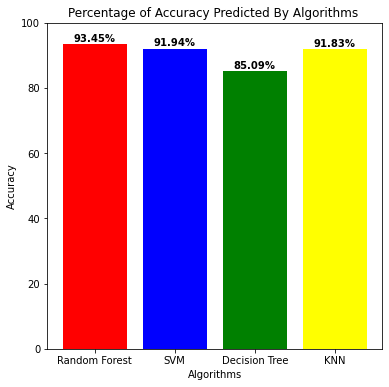

In [33]:
# Building Accuracy Graph
acc_dc=(accuracy_dc*100).round(decimals=2)
acc_rf=(accuracy_rf*100).round(decimals=2)
acc_svm=(accuracy_svm*100).round(decimals=2)
acc_knn=np.float64(91.83)
data = pd.DataFrame({'alg':['Random Forest','SVM','Decision Tree','KNN'],'per': [acc_rf,acc_svm,acc_dc,acc_knn]})
percentage = [acc_rf,acc_svm,acc_dc,acc_knn]
data['Percentage'] = percentage
plt.figure(figsize=(6,6))
colors_list = ['red','blue','green','yellow']
graph = plt.bar(data.alg,data.per ,color = colors_list)
plt.title('Percentage of Accuracy Predicted By Algorithms ')
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
            y+height*1.01,
            str(data.Percentage[i])+'%',
            ha='center',
            weight='bold')
    i+=1
plt.ylim(0,100)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.show()